# IMPORTS

In [2]:
import mne
import numpy as np
import pandas as pd
import shap

from scipy.stats import skew, kurtosis
from mne.datasets.sleep_physionet.age import fetch_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. TEMP MNE PHYSIONET DATA 

In [ ]:
ALICE, BOB = 0, 1
# The subjects to use. Can be in the range of 0-82 (inclusive), however
# the following subjects are not available: 39, 68, 69, 78 and 79.

[alice_files, bob_files] = (
    fetch_data(subjects=[ALICE, BOB], recording=[1])
)

raw_train_alice = mne.io.read_raw_edf(
    alice_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error",
)
annot_train_alice = mne.read_annotations(alice_files[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


# 2. REAL PATIENT DATA

In [ ]:
files = ["/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces.edf",
         "/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces_annotations.edf"]

files_temp = ["/home/user/mne_data/physionet-sleep-data/SC4001E0-PSG.edf",
         "/home/user/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf"]

psg_data = mne.io.read_raw_edf(files[0], preload=True)
annotations = mne.read_annotations(files[1])

psg_data.set_annotations(annotations)


sfreq = psg_data.info['sfreq'] #frekans

Extracting EDF parameters from /home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5679103  =      0.000 ... 22183.996 secs...


/tmp/ipykernel_1683822/3262215050.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data.set_annotations(annotations)


# 3. MEMMAP VERSION

In [ ]:
sfreq = psg_data.info['sfreq']

epoch_length = 30  # seconds
samples_per_epoch = int(epoch_length * sfreq)
n_epochs = len(annotations)
n_channels = len(psg_data.ch_names)

# TODO 21.04.25 float16 ile denenecek
X_epochs = np.memmap('epochs.dat', dtype='float32', mode='w+',
                     shape=(n_epochs, n_channels, samples_per_epoch))

for i in range(n_epochs):
    start_sample = i * samples_per_epoch
    end_sample = start_sample + samples_per_epoch
    
    if end_sample <= psg_data.n_times:
        X_epochs[i] = psg_data.get_data(start=start_sample, stop=end_sample)

X_epochs.flush()

# Labels
y = [annot['description'] for annot in annotations]


In [ ]:
def extract_features(epoch, channel_names):
    """Her epoch için özellik çıkaran fonksiyon"""
    features = {}
    stats = {
        "mean": np.mean(epoch, axis=1),
        "std": np.std(epoch, axis=1),
        "skewness": skew(epoch, axis=1),
        "kurtosis": kurtosis(epoch, axis=1),
        "power": np.sum(epoch**2, axis=1),
    }
    
    for stat_name, values in stats.items():
        for ch_idx, value in enumerate(values):
            features[f"{stat_name}_{channel_names[ch_idx]}"] = value
    
    return features


#feature_list = [extract_features(epoch.copy()) for epoch in X_epochs] # .copy() for speed

channel_names = psg_data.info['ch_names']  # Get real channel names
feature_list = [extract_features(epoch, channel_names) for epoch in X_epochs]

df_features = pd.DataFrame(feature_list)

df_features["sleep_stage"] = y


/tmp/ipykernel_1683822/1932215746.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skewness": skew(epoch, axis=1),
/tmp/ipykernel_1683822/1932215746.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": kurtosis(epoch, axis=1),


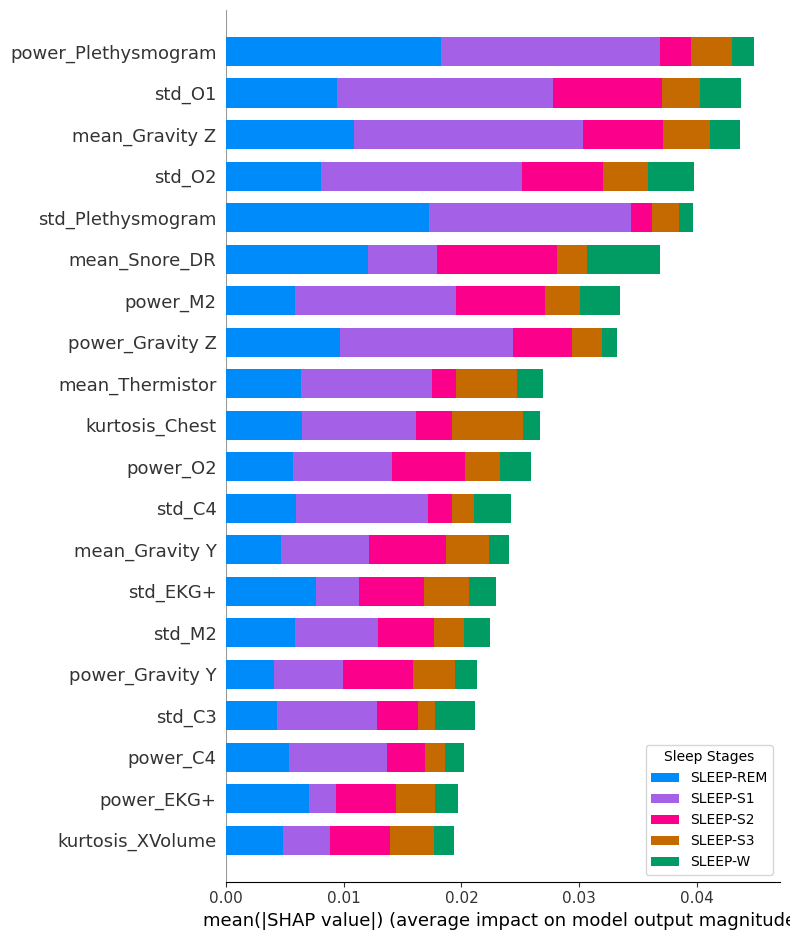

In [ ]:
X = df_features.drop(columns=["sleep_stage"])
y = df_features["sleep_stage"]

# TODO 21.04.25 Toplantıdan > ! zaman serisi yapıldığında, shuffle off yapılacak 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Farklı classiifier'lar denenecek, SVM gibi
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, show=False)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
class_labels = clf.classes_  # ['Wake', 'N1', 'N2', 'N3', 'REM']
plt.legend(handles, class_labels, title="Sleep Stages")
plt.show()
# TODO 21.04.25 Toplantıdan > ! her bir feature için stage oranlarının fazla olduğu ikili channel olarak seçilebilir.

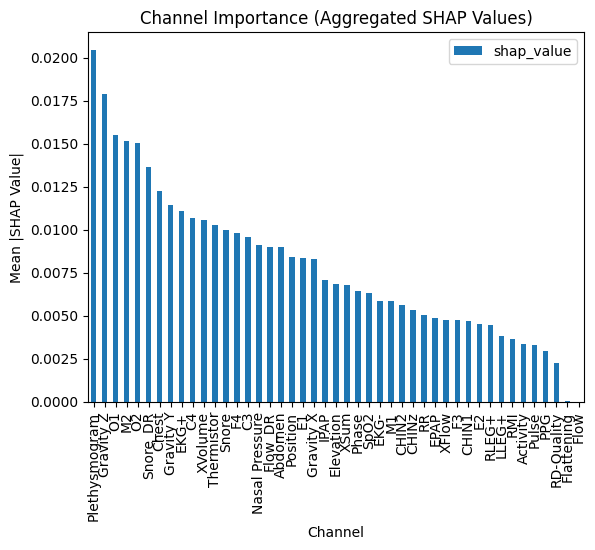

<Figure size 1500x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=(0, 2))  # shape: (features,)

feature_names = X_test.columns
channel_names = [name.split('_', 1)[1] for name in feature_names]  # assuming 'power_C3' → 'C3'

channel_importance = pd.DataFrame({'channel': channel_names, 'shap_value': mean_abs_shap})
channel_summary = channel_importance.groupby('channel').sum().sort_values(by='shap_value', ascending=False)

channel_summary.plot(kind='bar')
plt.title("Channel Importance (Aggregated SHAP Values)")
plt.ylabel("Mean |SHAP Value|")
plt.xlabel("Channel")
plt.figure().set_figwidth(15)
plt.show()

In [27]:
print([name for name in feature_names])

['mean_C3', 'mean_C4', 'mean_F3', 'mean_F4', 'mean_O1', 'mean_O2', 'mean_M1', 'mean_M2', 'mean_E1', 'mean_E2', 'mean_CHIN1', 'mean_CHIN2', 'mean_CHINz', 'mean_EKG+', 'mean_EKG-', 'mean_RLEG+', 'mean_LLEG+', 'mean_Snore', 'mean_Thermistor', 'mean_Nasal Pressure', 'mean_Flow_DR', 'mean_Snore_DR', 'mean_Abdomen', 'mean_Chest', 'mean_Phase', 'mean_RMI', 'mean_RR', 'mean_XSum', 'mean_XFlow', 'mean_XVolume', 'mean_Position', 'mean_Elevation', 'mean_Activity', 'mean_PPG', 'mean_Plethysmogram', 'mean_Flow', 'mean_EPAP', 'mean_IPAP', 'mean_SpO2', 'mean_Pulse', 'mean_RD-Quality', 'mean_Gravity X', 'mean_Gravity Y', 'mean_Gravity Z', 'mean_Flattening', 'std_C3', 'std_C4', 'std_F3', 'std_F4', 'std_O1', 'std_O2', 'std_M1', 'std_M2', 'std_E1', 'std_E2', 'std_CHIN1', 'std_CHIN2', 'std_CHINz', 'std_EKG+', 'std_EKG-', 'std_RLEG+', 'std_LLEG+', 'std_Snore', 'std_Thermistor', 'std_Nasal Pressure', 'std_Flow_DR', 'std_Snore_DR', 'std_Abdomen', 'std_Chest', 'std_Phase', 'std_RMI', 'std_RR', 'std_XSum', 'st

In [31]:
top_channels = channel_summary.head(7)
print(top_channels)

               shap_value
channel                  
Plethysmogram    0.020466
Gravity Z        0.017868
O1               0.015506
M2               0.015180
O2               0.015015
Snore_DR         0.013668
Chest            0.012262
